# Consumer Sentiment: Uber Supply side analysis

### Mainly focusing on how the sentiments have changed with the introduction of In-App Tiping

The main two sources of data:
   * [Indeed](https://www.indeed.com/cmp/Uber-Partner-Drivers/reviews?fjobtitle=Driver+(Independent+Contractor))
   * [Uberpeople](https://uberpeople.net/forums/Gratuity/)
   
   
We plan to use the Indeed reviews to build a classifier model to classify the sentiment of the text given a set of words. The class is defined as positive or negative based on the star ratings for the review which is weighed using the up_vote and down_votes

In [109]:
#calling all the dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from nltk import bigrams
from nltk.corpus import stopwords
import string
import re
import us
import numpy as np
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk import bigrams, FreqDist
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
from textblob import TextBlob

In [2]:
data = pd.read_csv('indeed_uber_data_final.csv') #reading the scraped data

In [3]:
data = data.drop('Unnamed: 0', axis = 1)

In [4]:
data.head() #displaying the first 5 rows of data

ratings       location        date  \
0      3.0     Boston, MA  2019-02-13   
1      3.0   Paterson, NJ  2019-03-17   
2      4.0    Houston, TX  2019-03-16   
3      5.0  Santa Ana, CA  2019-03-16   
4      5.0     Tucson, AZ  2019-03-14   

                                               pro  \
0                                              NaN   
1                                            Diver   
2  get familiar with the city and surrounding area   
3                                              NaN   
4                              Work when I want to   

                                                 con  up_vote  down_vote  \
0                                                NaN      4.0        NaN   
1                       Some area are bad and u safe      NaN        NaN   
2  maintenance on car, mileage adds up. Sometimes...      NaN        NaN   
3                                                NaN      NaN        NaN   
4                                      Traffic hours      NaN        NaN   

                                             message  
0  Initially was excellent. Has become saturated ...  
1  I like the job but doesn’t pay what I need to ...  
2  Only 2 reasons I am quitting is not enough mon...  
3  Uber is a great job where you can communicate ...  
4  Monday, Wednesday, Friday, Saturday and Sunday...

In [5]:
print("Number of driver reviews: " + str(data.shape[0]))

Number of driver reviews: 4343


Text(0.5,1,'Frequence map for Ratings')

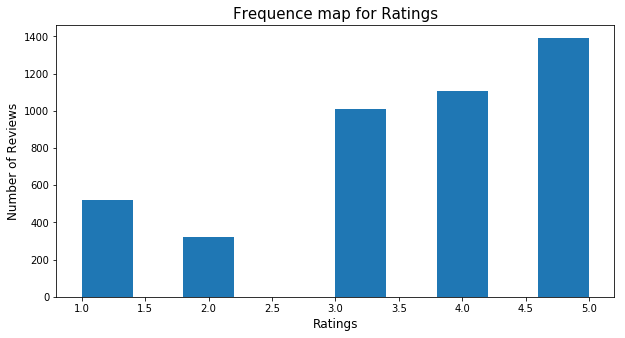

In [6]:
#plot to see the distribution of ratings across the board
plt.figure(figsize=(10,5))
plt.hist(data.ratings)
plt.xlabel('Ratings', size = 12)
plt.ylabel('Number of Reviews', size = 12)
plt.title('Frequence map for Ratings', size = 15)

In [7]:
data.groupby(['ratings'])['message'].count()

ratings
1.0     519
2.0     319
3.0    1009
4.0    1104
5.0    1392
Name: message, dtype: int64

#### We see that the number of 4 & 5 star ratings are more than the lower ratings. Using the theory of loss aversion we would take the ratings equal to or higher than 4 as positive and lower of equal than 3 as negative

In [8]:
data.dtypes #checking the data types of the data colums

ratings      float64
location      object
date          object
pro           object
con           object
up_vote      float64
down_vote    float64
message       object
dtype: object

### Data cleaning

This is a necessary step in natural language processing as this reduces the noise in the data drastically

In [9]:
#getting the states from the location column
data['location'] = data['location'].str.lower()
data['location'] = data['location'].str.replace('\d+','')
data['location'] = data['location'].str.strip()

In [10]:
abr = [state.abbr.lower() for state in us.states.STATES] #list of all US state abbrevations

In [11]:
data['states'] = [state[-2:].strip() for state in data.location] #extracting states from location specified

In [12]:
#some states do not have abbreviations but the entier state name
#this loop gets the abbreviations for those states using US library in python to get data
i = 0
del_index = []
for state in data.states:
    if state in abr:
        i+=1
    elif us.states.lookup(data.at[i,'location']) is None:
        del_index.append(i)
        i+=1
    else:
        data.at[i,'states'] = us.states.lookup(data.at[i,'location']).abbr.lower()
        i+=1

In [13]:
#some states are not from unites states, we remove those values as our focus is only on United States
data.drop(del_index, inplace= True)
data.reset_index(inplace=True, drop=True) 

In [14]:
data.nunique() #number of unique entries in each column

ratings         5
location      756
date         1242
pro          1691
con          2143
up_vote       154
down_vote     109
message      3979
states         50
dtype: int64

In [15]:
#imputing the missing values
data[['pro', 'con']] = data[['pro', 'con']].fillna('')
data[['up_vote', 'down_vote']] = data[['up_vote', 'down_vote']].fillna(0)

In [16]:
data.isna().sum() #check if all the "NaN" values have be filled

ratings      0
location     0
date         0
pro          0
con          0
up_vote      0
down_vote    0
message      0
states       0
dtype: int64

In [17]:
data.head() #ensuring the fucntions act as we want them to

ratings       location        date  \
0      3.0     boston, ma  2019-02-13   
1      3.0   paterson, nj  2019-03-17   
2      4.0    houston, tx  2019-03-16   
3      5.0  santa ana, ca  2019-03-16   
4      5.0     tucson, az  2019-03-14   

                                               pro  \
0                                                    
1                                            Diver   
2  get familiar with the city and surrounding area   
3                                                    
4                              Work when I want to   

                                                 con  up_vote  down_vote  \
0                                                         4.0        0.0   
1                       Some area are bad and u safe      0.0        0.0   
2  maintenance on car, mileage adds up. Sometimes...      0.0        0.0   
3                                                         0.0        0.0   
4                                      Traffic hours      0.0        0.0   

                                             message states  
0  Initially was excellent. Has become saturated ...     ma  
1  I like the job but doesn’t pay what I need to ...     nj  
2  Only 2 reasons I am quitting is not enough mon...     tx  
3  Uber is a great job where you can communicate ...     ca  
4  Monday, Wednesday, Friday, Saturday and Sunday...     az

In [18]:
stop_words = stopwords.words('english') + list(string.punctuation) #list of stop words and punctuations
extra_stop_words = ['uber', 'get', 'able', 'abad', '`']
stop_words = stop_words + extra_stop_words

In [19]:
""" this fucntion is used to apply all the cleaning steps to the data text columns"""
def data_cleaning(combined_text):
    text = combined_text.lower() #converts everything to lower case charecters
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)#replaces all the punctuations with none
    text = re.sub('\w*\d\w*', '', text) #removes all the numbers
    text = text.replace('\n','') #replaces all the tab charecters
    text = text.replace('\t','')#replaces all the tab charecters
    text = [i for i in word_tokenize(text) if i not in stop_words] #removing stop words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text] #Lemmantizing every word
    
    return text

In [20]:
#the data before cleaning looks like
data.message[0]

'Initially was excellent. Has become saturated now with way too many drivers and fares have been reduc d significantly while the percentage uber receive has increased'

In [21]:
#data_cleaning removes all the punctuations and stop words, this allows us to focus only on meaningfull data
data_cleaning(data.message[0])

['initially',
 'excellent',
 'become',
 'saturated',
 'way',
 'many',
 'driver',
 'fare',
 'reduc',
 'significantly',
 'percentage',
 'receive',
 'increased']

In [22]:
#applying the data cleaner to all the text columns
data['clean_message'] =  data['message'].apply(data_cleaning)
data['clean_pro'] =  data['pro'].apply(data_cleaning)
data['clean_con'] =  data['con'].apply(data_cleaning)

### Creating weighted rating system based on up and down votes

This is done in order to rate the reviews based on their number of up and down votes, we subtract the number of downvotes from upvotes and divide them by the total number of upvotes. Finally the weight is added to the stars given.

In [23]:
#creating a column for weights:
weight = []
dist = np.array(abs(data.up_vote - data.down_vote))
for i in range(data.shape[0]):
    diff = data.up_vote[i] - data.down_vote[i]
    if  diff < 0:
        if abs(diff) < 65:
            if data.ratings[i] > 3:
                weight.append(-0.5)
            elif data.ratings[i] <= 3:   
                weight.append(0.5)
        else:
            if data.ratings[i] > 3:
                weight.append(-1)
            elif data.ratings[i] <= 3:   
                weight.append(1)
    else:
        weight.append(0)        

In [24]:
data['weighed_rankings'] = data.ratings+np.round(np.array(weight),1)
data.weighed_rankings.round(2)
data.head()

ratings       location        date  \
0      3.0     boston, ma  2019-02-13   
1      3.0   paterson, nj  2019-03-17   
2      4.0    houston, tx  2019-03-16   
3      5.0  santa ana, ca  2019-03-16   
4      5.0     tucson, az  2019-03-14   

                                               pro  \
0                                                    
1                                            Diver   
2  get familiar with the city and surrounding area   
3                                                    
4                              Work when I want to   

                                                 con  up_vote  down_vote  \
0                                                         4.0        0.0   
1                       Some area are bad and u safe      0.0        0.0   
2  maintenance on car, mileage adds up. Sometimes...      0.0        0.0   
3                                                         0.0        0.0   
4                                      Traffic hours      0.0        0.0   

                                             message states  \
0  Initially was excellent. Has become saturated ...     ma   
1  I like the job but doesn’t pay what I need to ...     nj   
2  Only 2 reasons I am quitting is not enough mon...     tx   
3  Uber is a great job where you can communicate ...     ca   
4  Monday, Wednesday, Friday, Saturday and Sunday...     az   

                                       clean_message  \
0  [initially, excellent, become, saturated, way,...   
1  [like, job, ’, pay, need, liveso, ’, looking, ...   
2  [reason, quitting, enough, money, wear, tear, ...   
3  [great, job, communicate, rider, fun, conversa...   
4  [monday, wednesday, friday, saturday, sunday, ...   

                             clean_pro  \
0                                   []   
1                              [diver]   
2  [familiar, city, surrounding, area]   
3                                   []   
4                         [work, want]   

                                           clean_con  weighed_rankings  
0                                                 []               3.0  
1                               [area, bad, u, safe]               3.0  
2  [maintenance, car, mileage, add, sometimes, un...               4.0  
3                                                 []               5.0  
4                                    [traffic, hour]               5.0

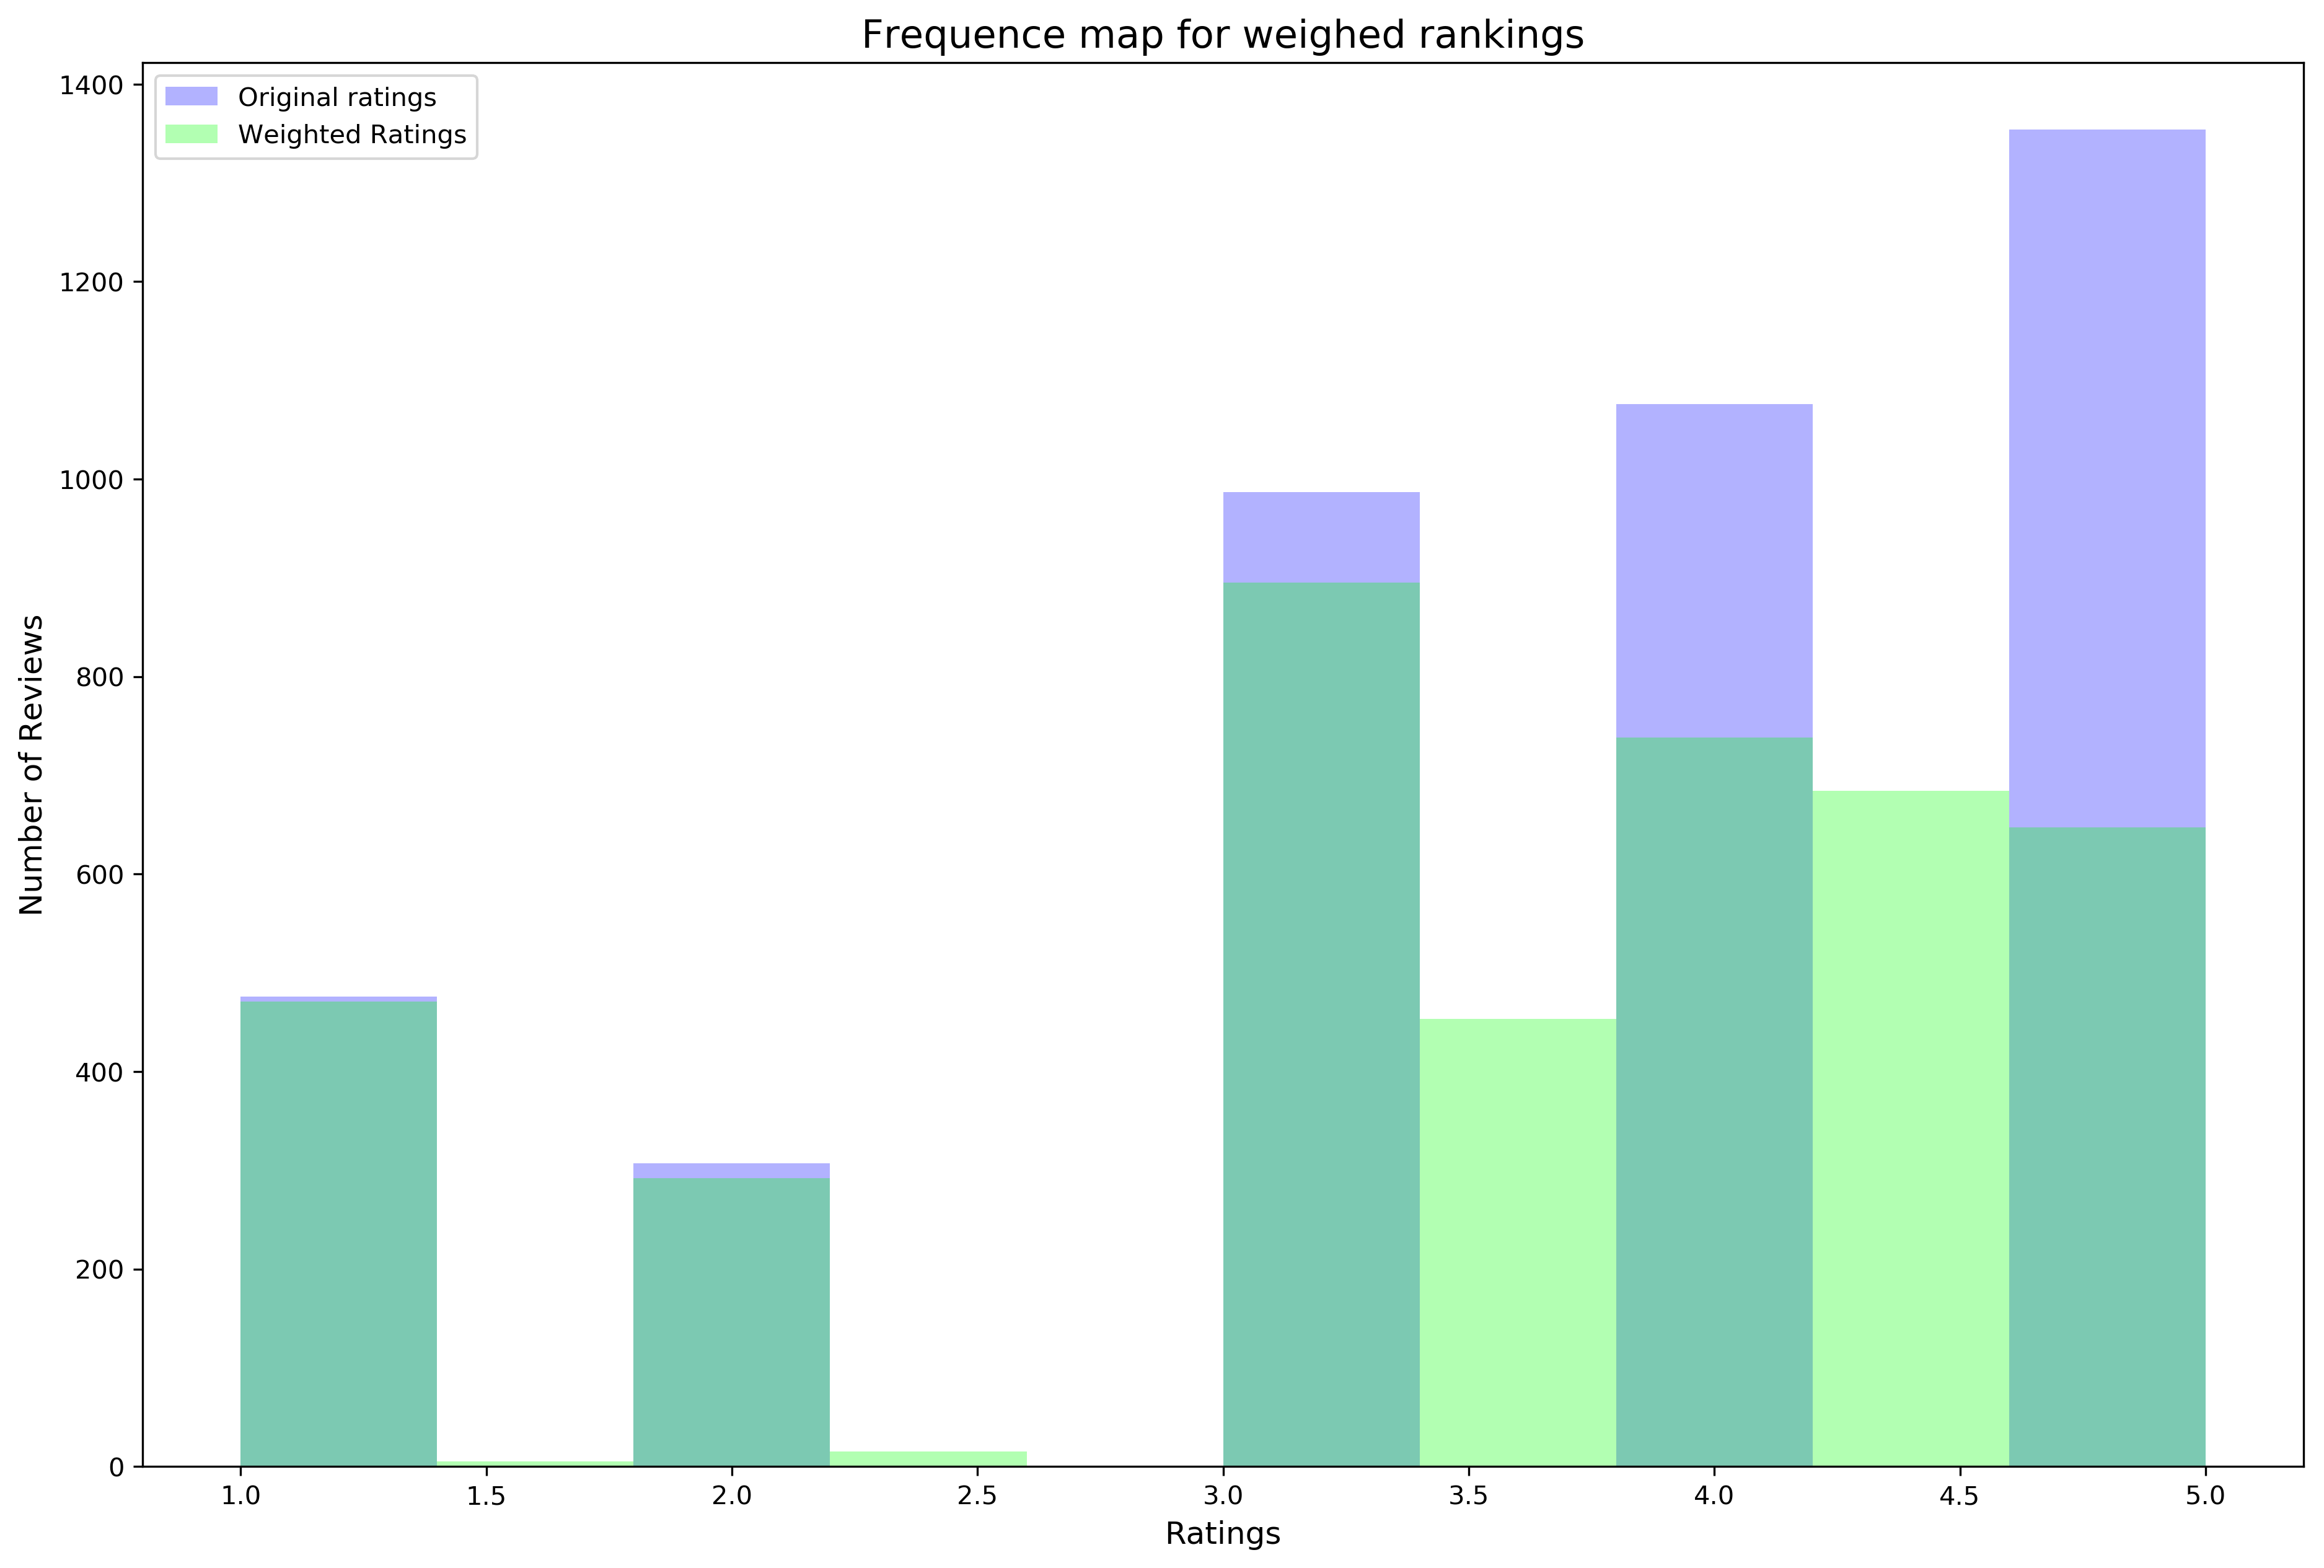

In [25]:
#plot to see the distribution of ratings across the board
plt.figure(figsize=(15,10), dpi = 300)
plt.hist(data.ratings,fc=(0,0,1,0.3))
plt.hist(data.weighed_rankings, fc=(0,1,0,0.3))
plt.xlabel('Ratings', size = 12)
plt.ylabel('Number of Reviews', size = 12)
plt.title('Frequence map for weighed rankings', size = 15)
plt.legend(['Original ratings', 'Weighted Ratings'])

In [26]:
pd.DataFrame(data.groupby(data.weighed_rankings.round(2))['message'].count())

message
weighed_rankings         
1.0                   471
1.5                     5
2.0                   292
2.5                    15
3.0                   895
3.5                   453
4.0                   738
4.5                   684
5.0                   647

In [27]:
"""This function takes in any text blob, tokenizes the blob and then extracts the bigrams from the same. 
It also gives back the Bigram count dictionary"""

def string_bigram_frequency(text_blob):
    
    tokens = word_tokenize(text_blob) #from the NLTK package
    bi_grams = []
    for txt in list(bigrams(tokens)): #bigrams is also from the NLTK package
        bi_grams.append((''.join([word + ' ' for word in txt])).strip())
    
    all_tokens = bi_grams  + tokens
    count_dict = Counter(all_tokens) #counter is from the collections package
    #bi_freq = Counter(bi_grams)
    #uni_freq = Counter(tokens)
    
    return count_dict

In [28]:
pro_blob = " ".join([" ".join(text) for text in data.clean_pro])
con_blob = " ".join([" ".join(text) for text in data.clean_con])
neg_msg_blob = " ".join([" ".join(text) for text in data[data.weighed_rankings <= 3.5].clean_message])
pos_msg_blob = " ".join([" ".join(text) for text in data[data.weighed_rankings > 3.5].clean_message])

In [29]:
pro_count_vector = string_bigram_frequency(pro_blob) 
con_count_vector = string_bigram_frequency(con_blob)
neg_msg_count_vector = string_bigram_frequency(neg_msg_blob)
pos_msg_count_vector = string_bigram_frequency(pos_msg_blob)

In [30]:
""" This function uses the word cloud package to create a word cloud plot which helps in visualizing """

def word_cloud_plot(text, title = "Word Cloud", mask = None):
    try:
        word_cloud = WordCloud(width=1600, height=800, max_font_size=200, mask = mask).generate(text)
    except:
        word_cloud = WordCloud(width=1600, height=800, max_font_size=200, mask = mask).fit_words(text)
        
    plt.figure(figsize=(20,15))
    plt.title(title, size = 25)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()   

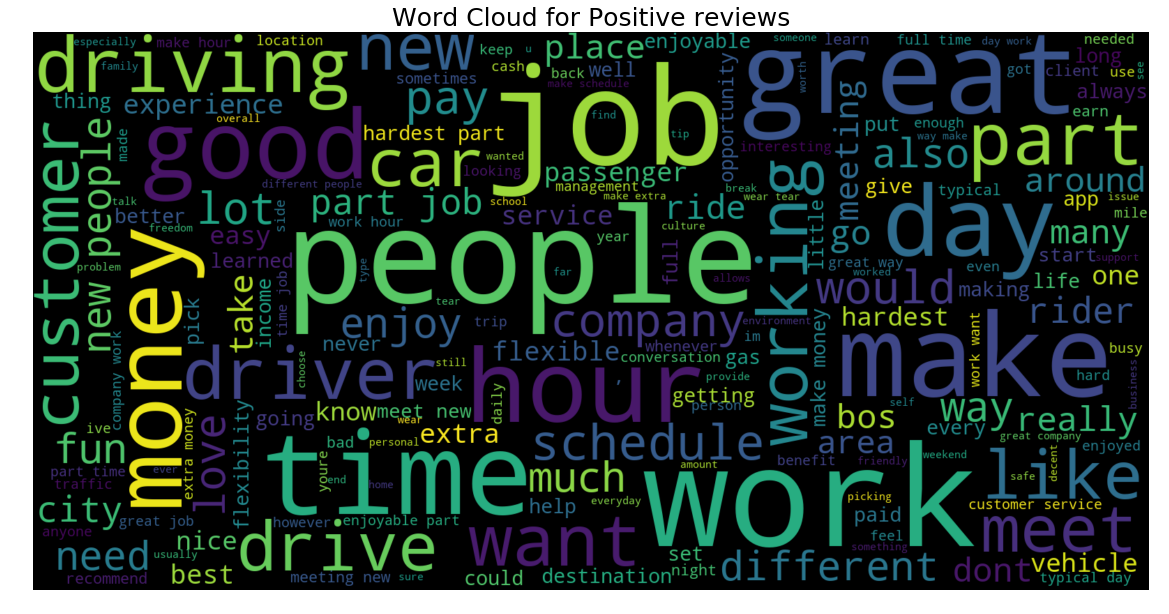

In [31]:
# Display the generated image:
word_cloud_plot(pos_msg_count_vector, "Word Cloud for Positive reviews")

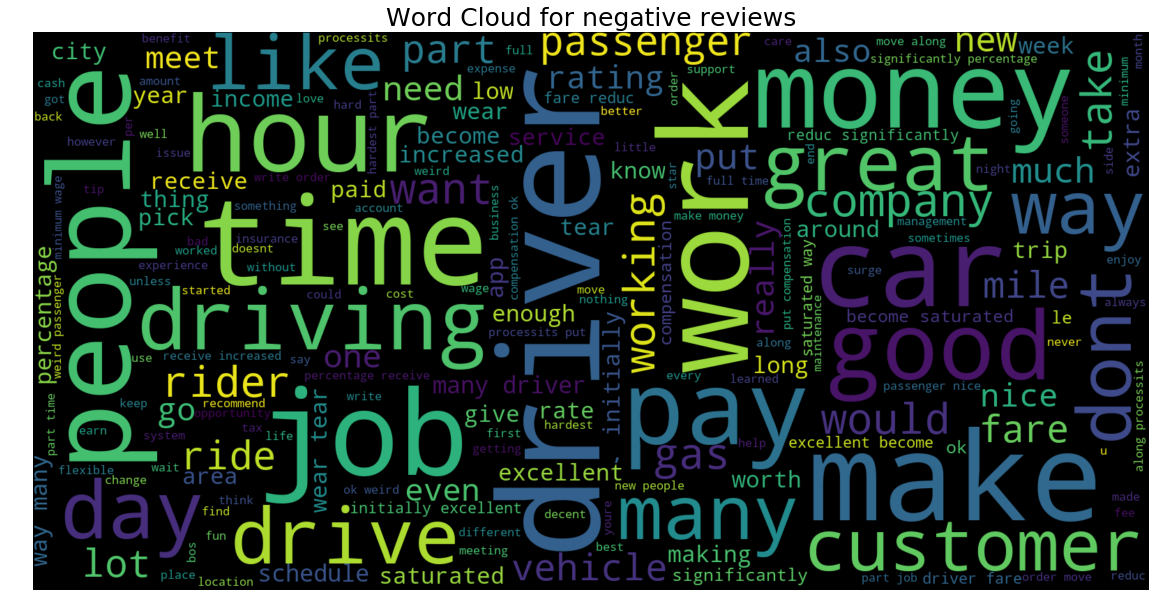

In [32]:
# Display the generated image:
word_cloud_plot(neg_msg_count_vector, "Word Cloud for negative reviews")

## Observations from the word cloud:

The first thing we observe is that the word Uber has the highest frequency in either cases, which is obvious because the reviews are of uber. Thus, it does not give away any information which is relevant to our analysis. There are few other words like "get", "put", "around" which do not give away much information. We can safely eliminate these words by adding them to the list of stop words.


#### The differences:

In the negative sentiment word cloud the terms like "pay", "gas", "customer" are present more as compared to the positive sentiment word cloud where the words like "People", "time", "hour", "flexibility" have been emphasized more. 

This gives us a clear picture of the distinctive ways they can be used together.

#### Same word different context:

There are certain terms which have the same word used in negative and the positive sense, for example the word "time" in a positive sentence reflects how they can be flexible with the times. On the contrary the word "time" in the negative sense may mean that they have to work for a longer time.


# Using Pro and Con to define polarity:

Here we mean to get polarity of the con and the pro for every document. We will use this value of polarity to define the overall weight by which we can edit the ratings of the reviews.

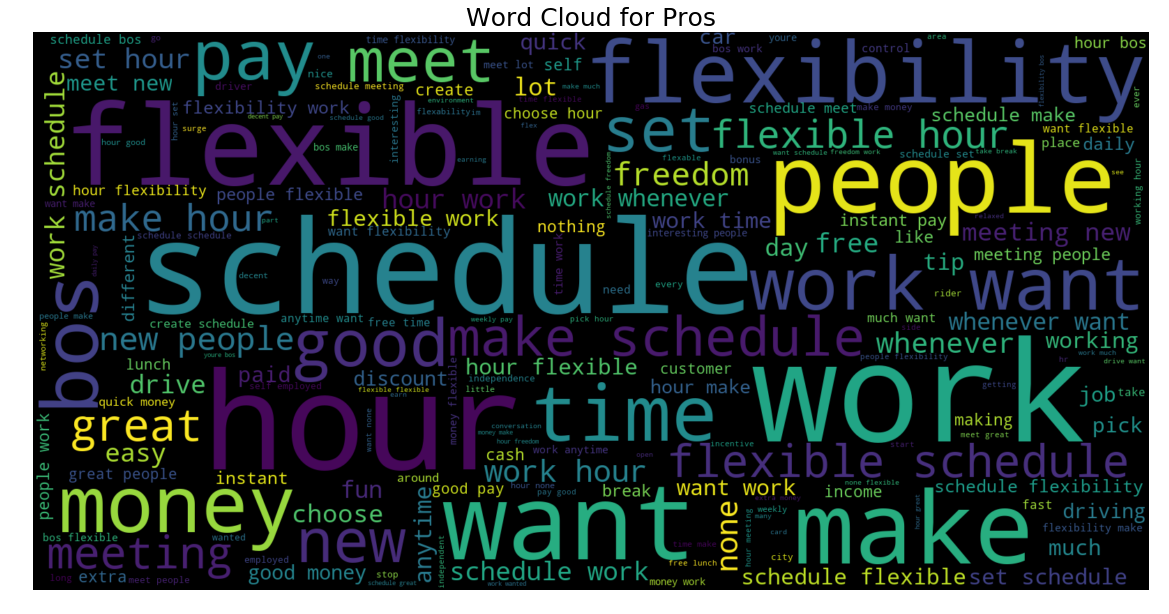

In [33]:
# Display the generated image:
word_cloud_plot(pro_count_vector, "Word Cloud for Pros")

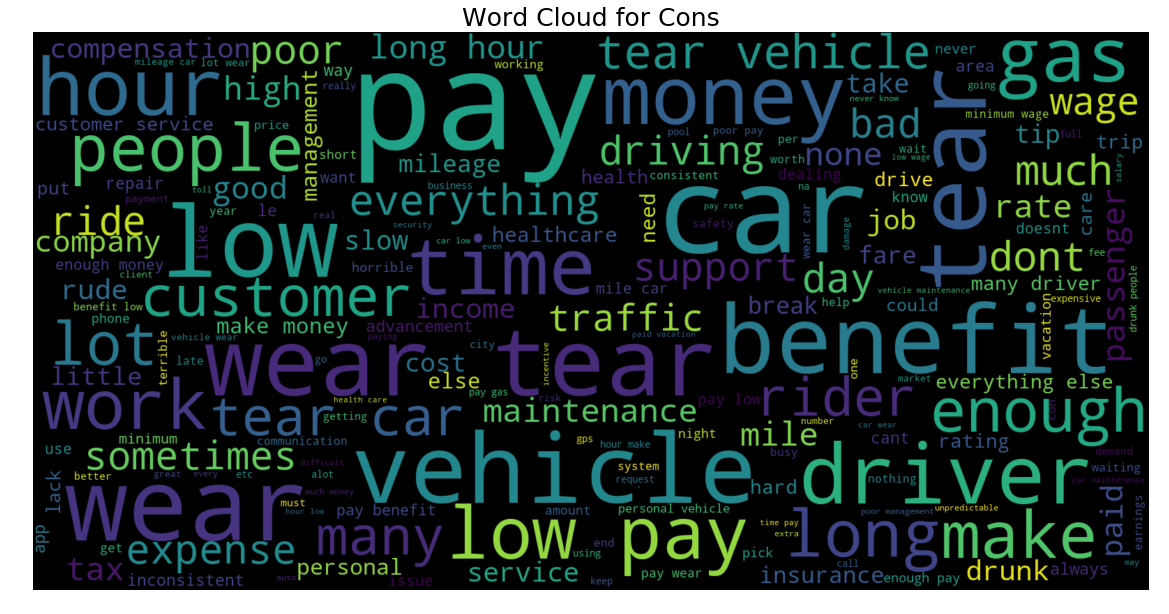

In [34]:
# Display the generated image:
word_cloud_plot(con_count_vector, "Word Cloud for Cons")

Let us extract the polarity scores for the positive and the negative reviews. We further add up the the polatiries, thus, the difference in the polarities in the cons and pros gives us an understanding of the overall polarity for the given review.

This information is further added in the main data frame getting the new_weights for the ratings!

In [35]:
pro_polarity = []
con_polarity = []

#this uses the TextBlob library to get the polarity of all the pro
for pro in data.clean_pro:
    pro_analysis = TextBlob(' '.join(pro))
    pro_polarity.append(pro_analysis.sentiment.polarity)

#this uses the TextBlob library to get the polarity of all the con    
for con in data.clean_con:
    con_analysis = TextBlob(' '.join(con))
    con_polarity.append(con_analysis.sentiment.polarity)

In [36]:
data['pro_polarity'] = pro_polarity
data['con_polarity'] = con_polarity

In [37]:
data['new_weighed_rankings'] = data.weighed_rankings + (data.pro_polarity + data.con_polarity)

##### To observe the difference between the original ratings and the final weighted ratings we plot all the three together.

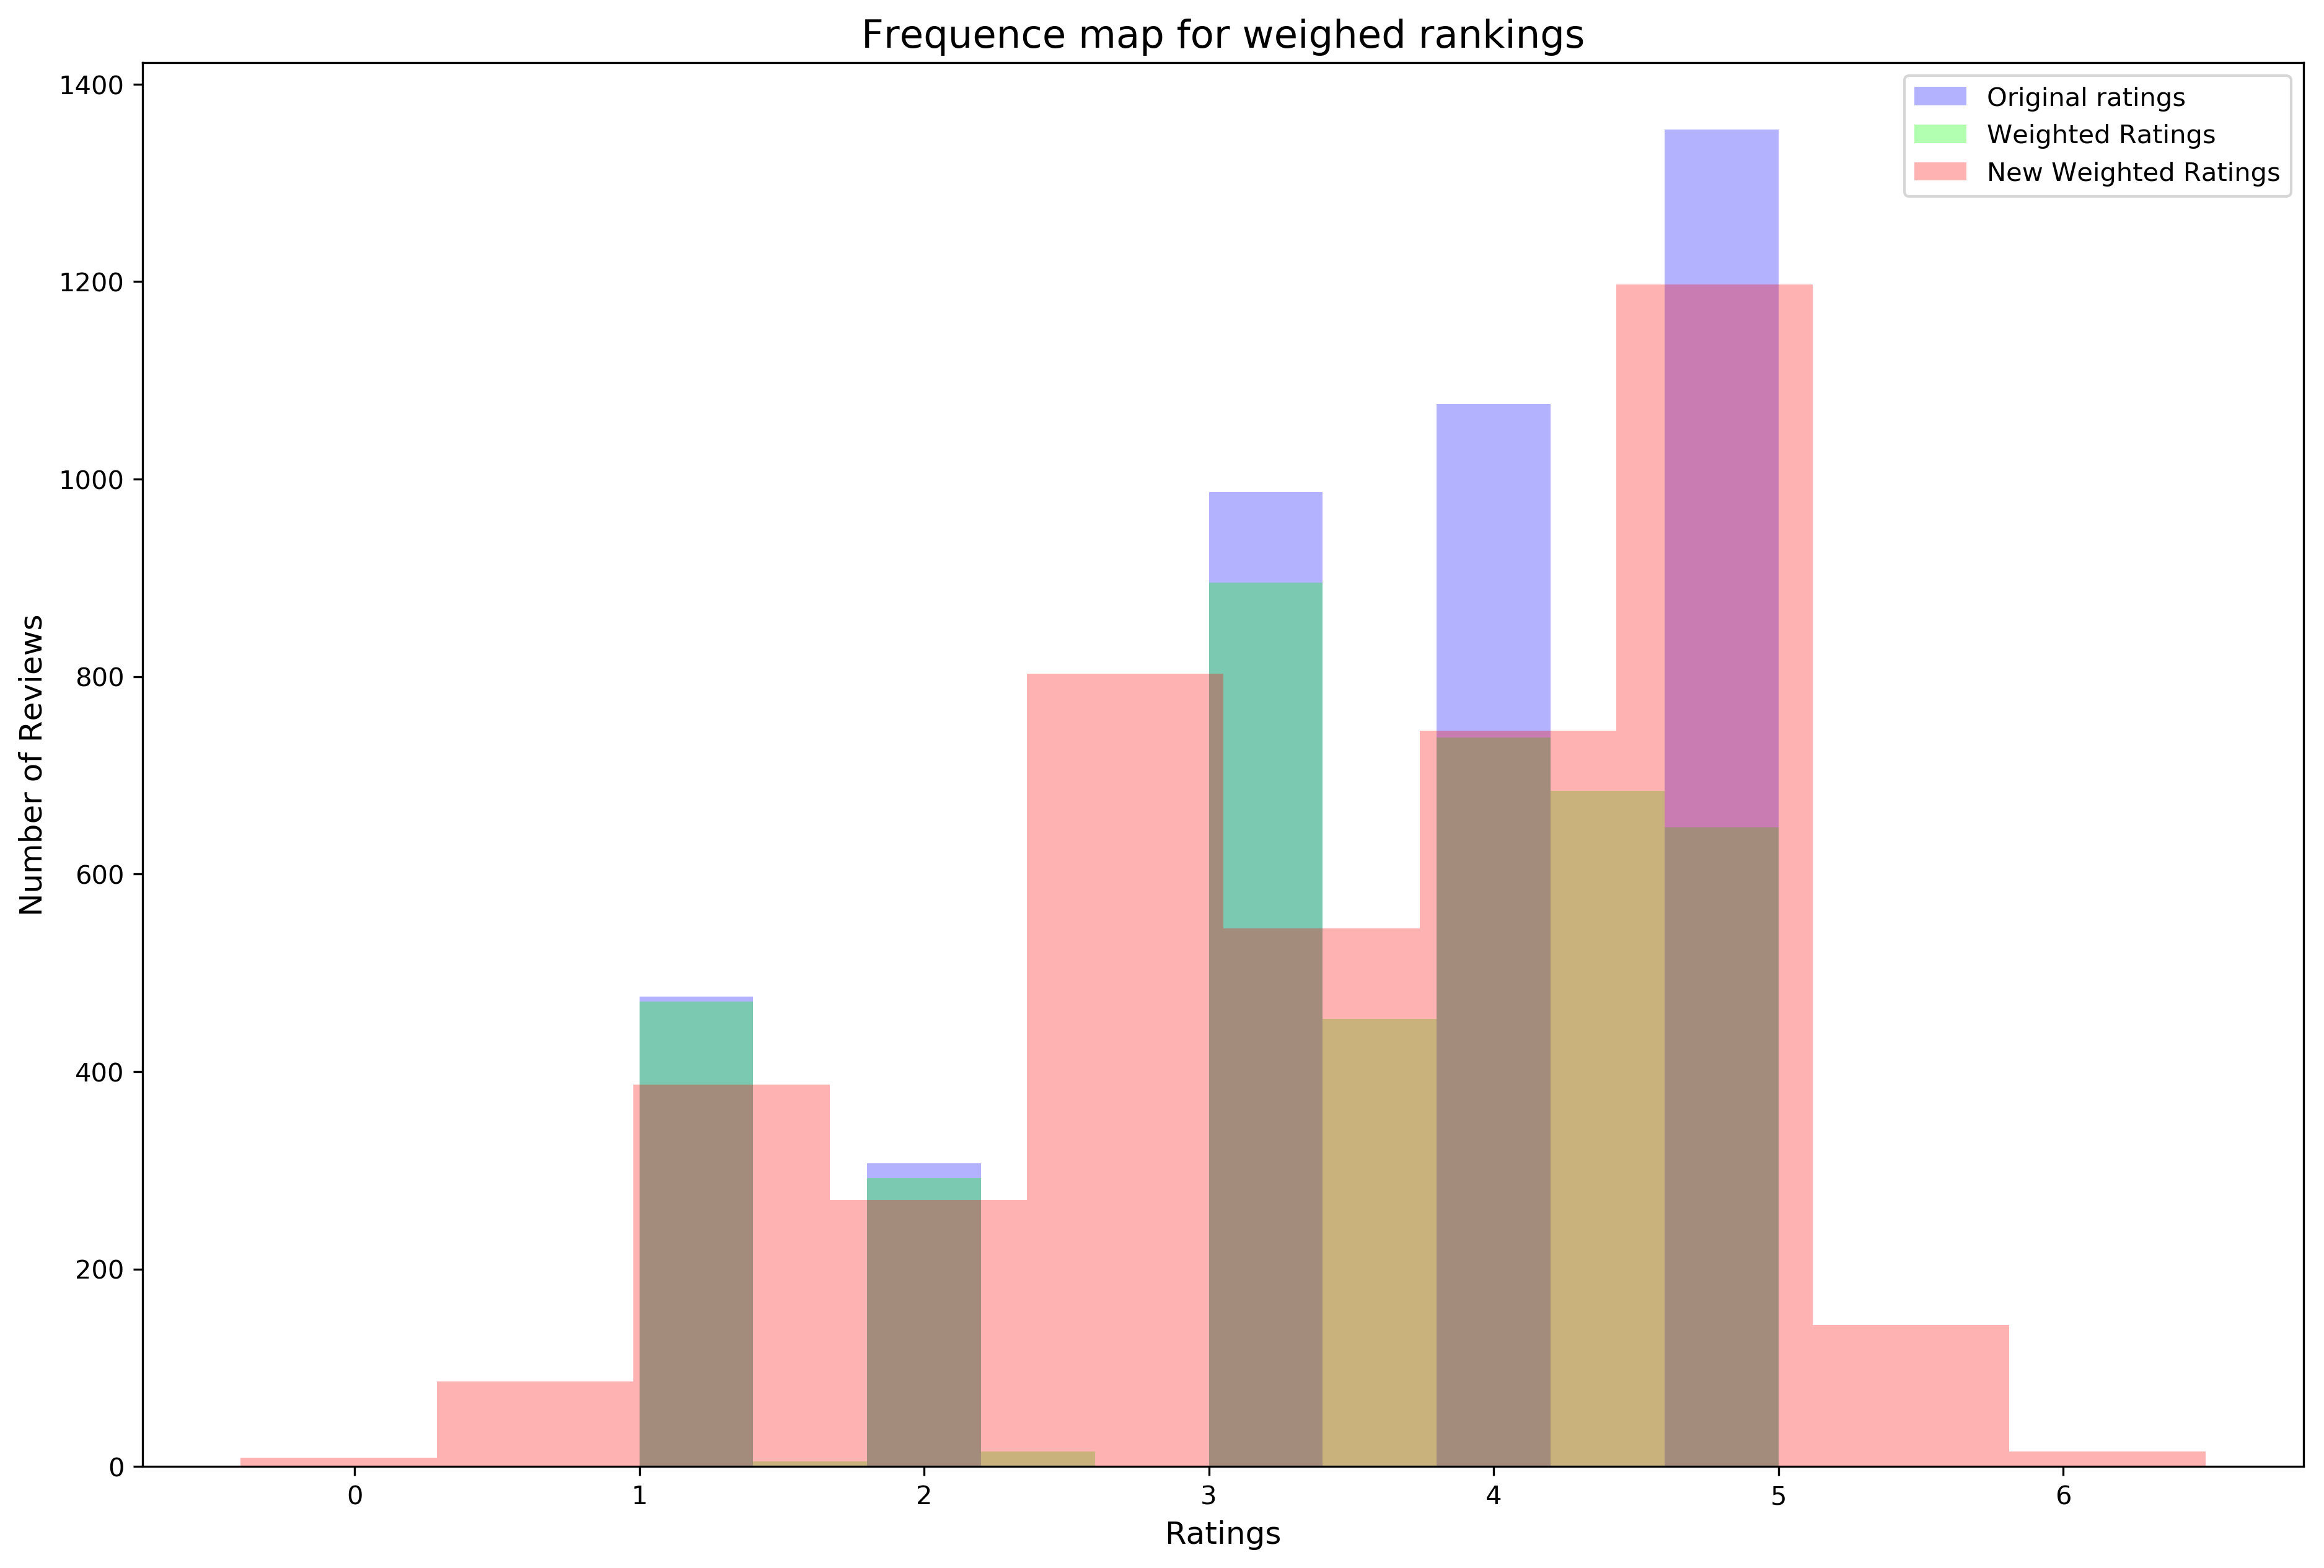

In [38]:
#plot to see the distribution of ratings across the board
plt.figure(figsize=(15,10), dpi = 300)
plt.hist(data.ratings,fc=(0,0,1,0.3))
plt.hist(data.weighed_rankings, fc=(0,1,0,0.3))
plt.hist(data.new_weighed_rankings.round(2), fc=(1,0,0,0.3))
plt.xlabel('Ratings', size = 12)
plt.ylabel('Number of Reviews', size = 12)
plt.title('Frequence map for weighed rankings', size = 15)
plt.legend(['Original ratings', 'Weighted Ratings', 'New Weighted Ratings'])

In [39]:
pd.DataFrame(data.groupby(data.new_weighed_rankings.round(0))['message'].count())

message
new_weighed_rankings         
0.0                        25
1.0                       421
2.0                       348
3.0                       890
4.0                      1706
5.0                       747
6.0                        63

##### Thus, we get a better distribution of the sentiments for the reviews. This will further allow us to convert the ratings system into a percentage based system.

In [48]:
data.new_weighed_rankings.describe() #we see that there are few ratings which have a negative rating

count    4200.000000
mean        3.529825
std         1.259596
min        -0.400000
25%         3.000000
50%         3.743182
75%         4.500000
max         6.500000
Name: new_weighed_rankings, dtype: float64

In [43]:
msg_polarity = []
for msg in data.message:
    msg_analysis = TextBlob(' '.join(msg))
    msg_polarity.append(msg_analysis.sentiment.polarity)

data['polarity_score'] = msg_polarity 
data['final_score'] = data.new_weighed_rankings + data.polarity_score

In [44]:
data[data.new_weighed_rankings < 0] #check the number of ratings with new ratings less than 0

ratings     location        date  pro  con  up_vote  down_vote  \
3557      1.0  hoboken, nj  2017-09-05  Bad  Bad      2.0        1.0   

                                                message states  \
3557  I dont like work for uber cuz uber dont pay go...     nj   

                                          clean_message clean_pro clean_con  \
3557  [dont, like, work, cuz, dont, pay, good, drivi...     [bad]     [bad]   

      weighed_rankings  pro_polarity  con_polarity  new_weighed_rankings  \
3557               1.0          -0.7          -0.7                  -0.4   

      polarity_score  final_score  
3557             0.0         -0.4

In [45]:
data.at[data[data.new_weighed_rankings < 0].index.values[0],'new_weighed_rankings'] = 0 
#substituting negative value with zero value

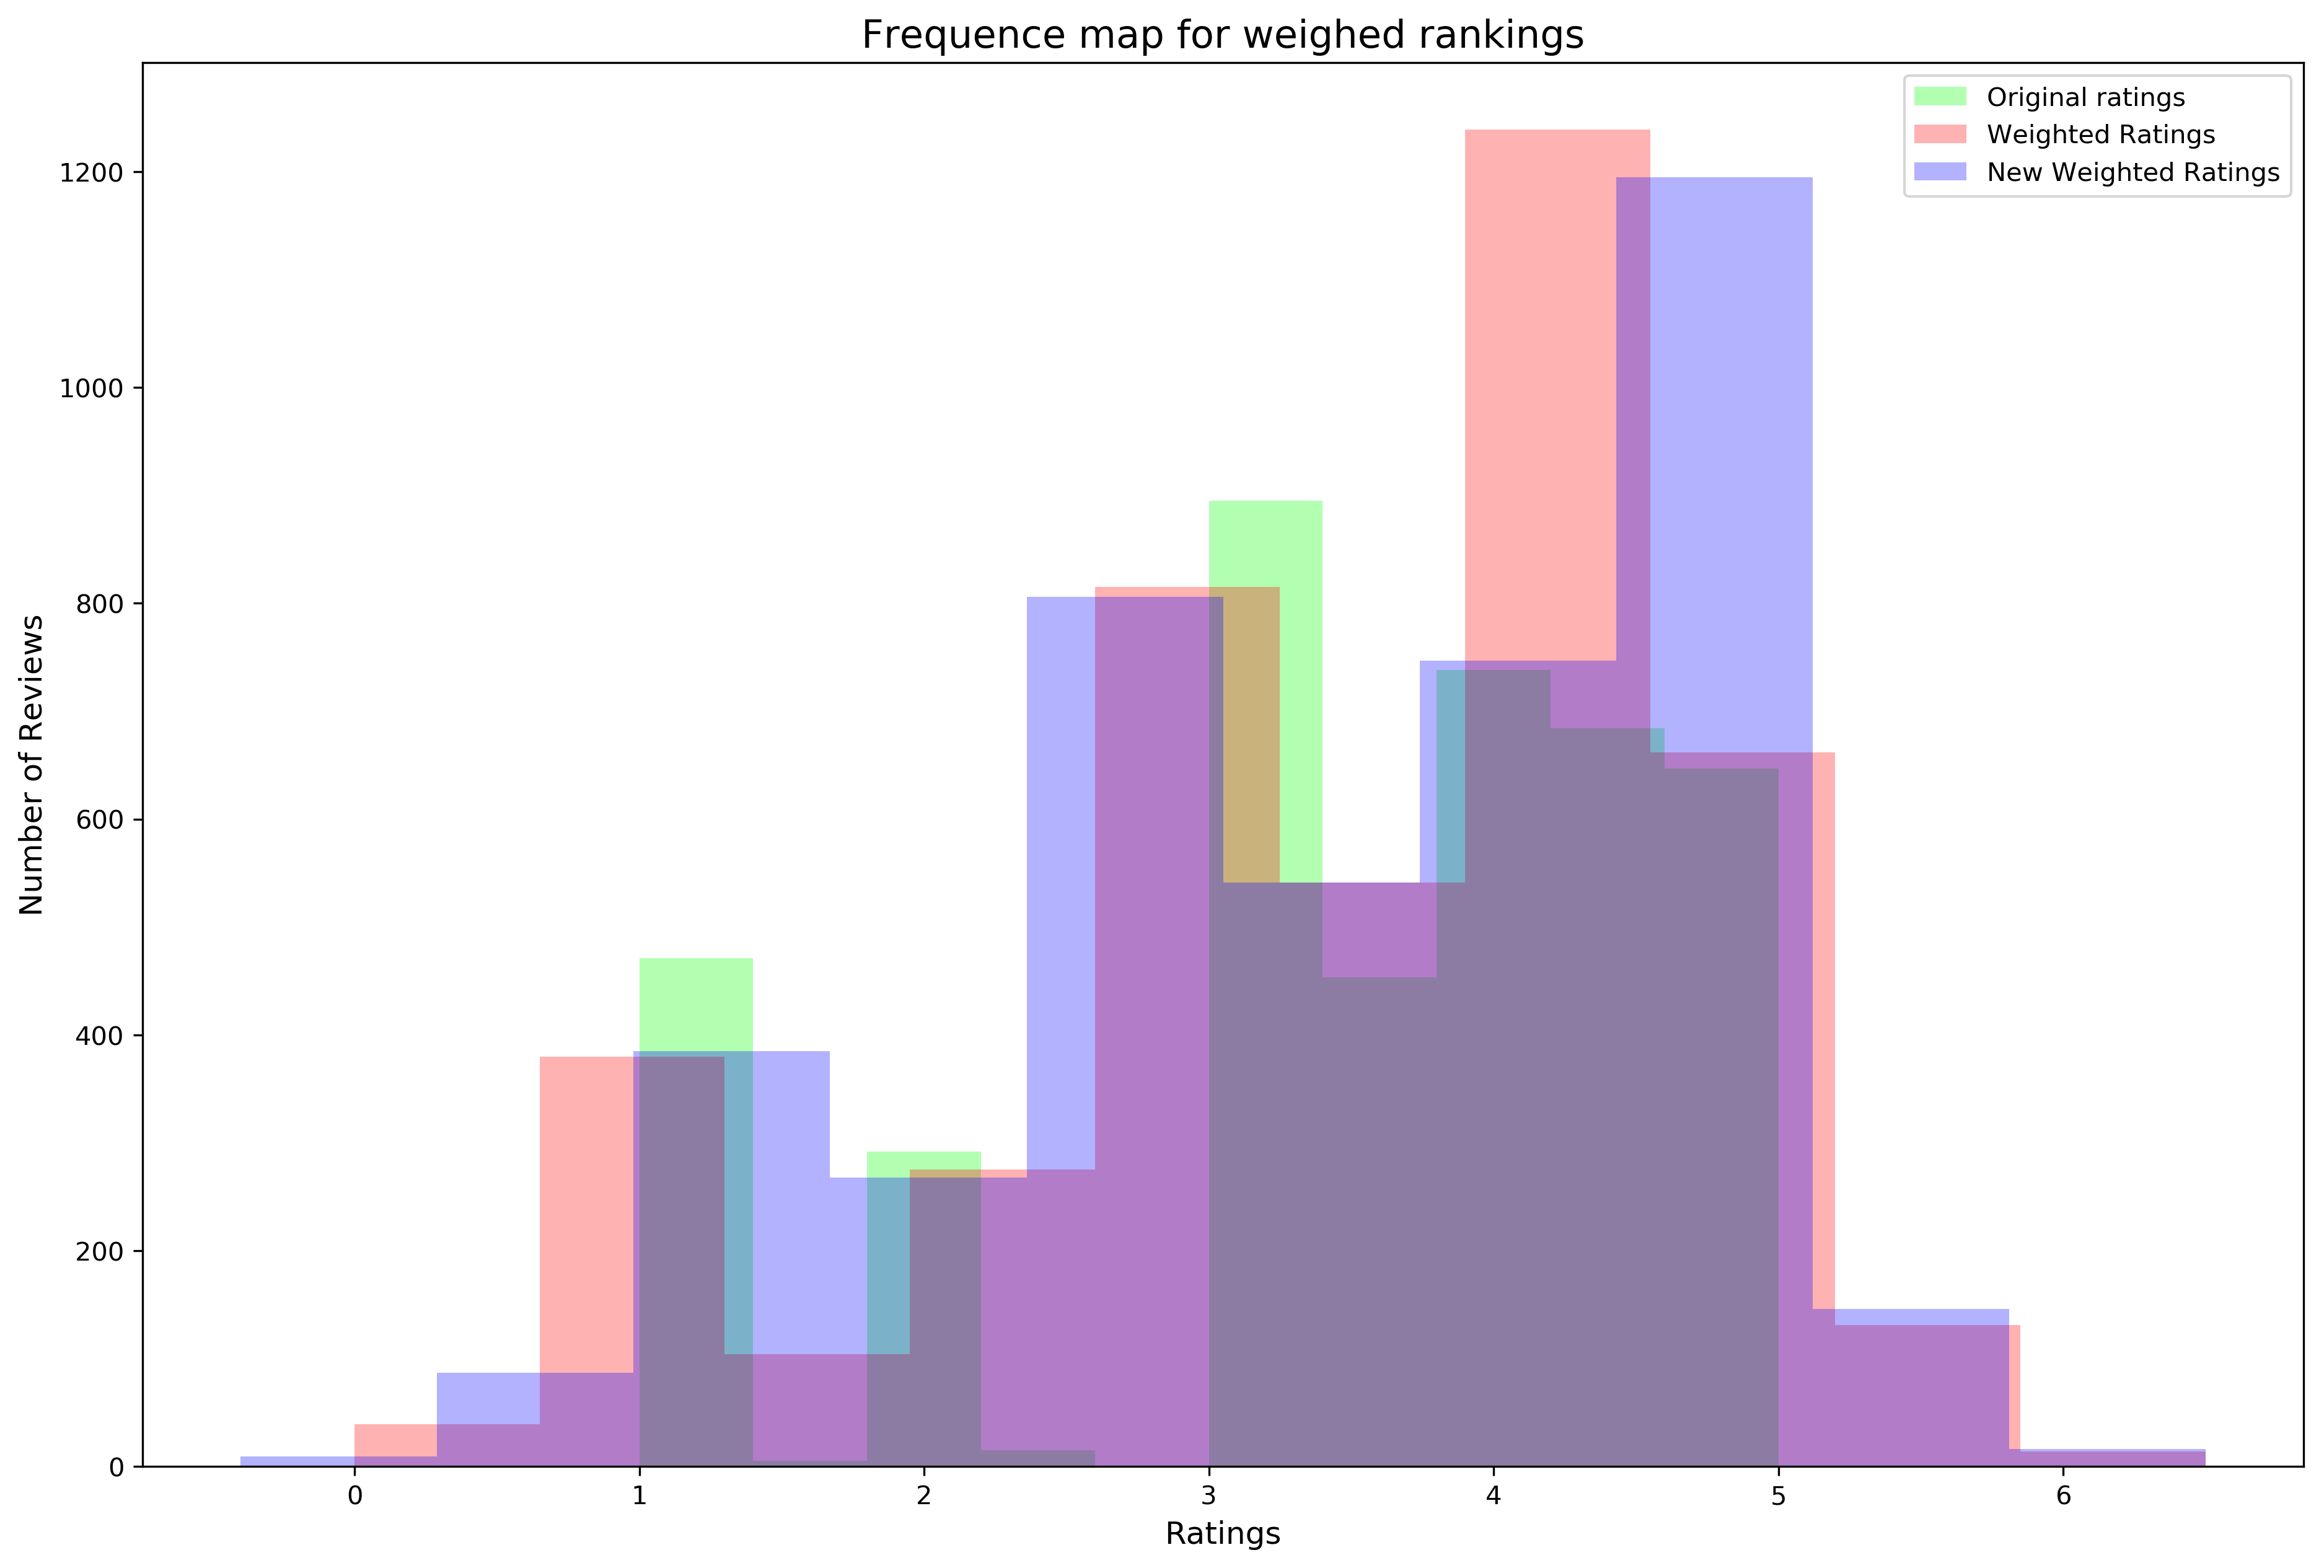

In [46]:
#plot to see the distribution of ratings across the board
plt.figure(figsize=(15,10), dpi = 300)
plt.hist(data.weighed_rankings, fc=(0,1,0,0.3))
plt.hist(data.new_weighed_rankings.round(2), fc=(1,0,0,0.3))
plt.hist(data.final_score.round(2), fc=(0,0,1,0.3))
plt.xlabel('Ratings', size = 12)
plt.ylabel('Number of Reviews', size = 12)
plt.title('Frequence map for weighed rankings', size = 15)
plt.legend(['Original ratings', 'Weighted Ratings', 'New Weighted Ratings'])

#### Now, let's conver this star rating into a percent based system!

In [47]:
data['percent_wt'] = [((x - min(data.final_score))/(max(data.final_score) - min(data.final_score)))*100 for x in data.final_score]

count    4200.000000
mean       56.980647
std        18.255027
min         0.000000
25%        49.275362
50%        60.144928
75%        71.014493
max       100.000000
Name: percent_wt, dtype: float64

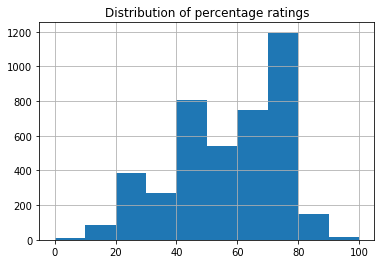

In [48]:
data.percent_wt.hist()
plt.title("Distribution of percentage ratings")
data.percent_wt.describe()

In [49]:
data.to_csv('cleaned_indeed_data.csv')

#### Thus, by converting the additional information into weights for the original ratings we were able to get a much better distributuin for the sentiments associated with the reviews. 

#### We will further check the polarity scores of the reviews to compare them to the actual weighted percentages we have

# Labelling the Sentiments

In [50]:
sentiment = []

for score in data.percent_wt:
    if score > 56:
        sentiment.append('positive')
    else:
        sentiment.append('negative')
        
data['sentiment'] = sentiment        

In [51]:
data.sentiment.unique()

array(['negative', 'positive'], dtype=object)

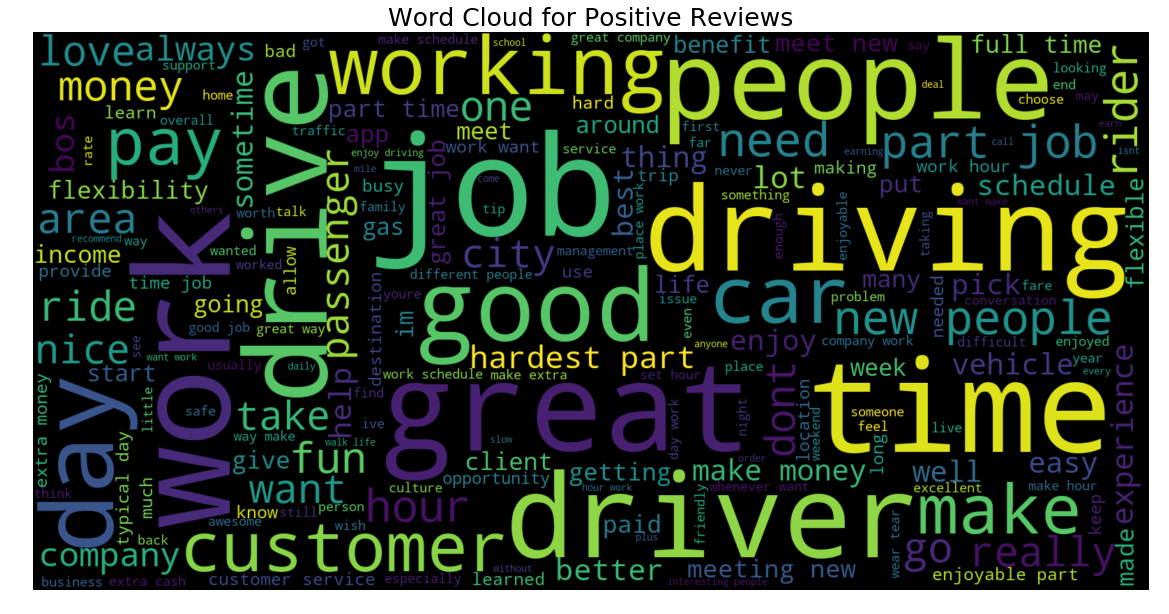

In [54]:
# Display the generated image:
word_cloud_plot(' '.join([' '.join(msg) for msg in data[data.percent_wt > 56].clean_message]),
                "Word Cloud for Positive Reviews")

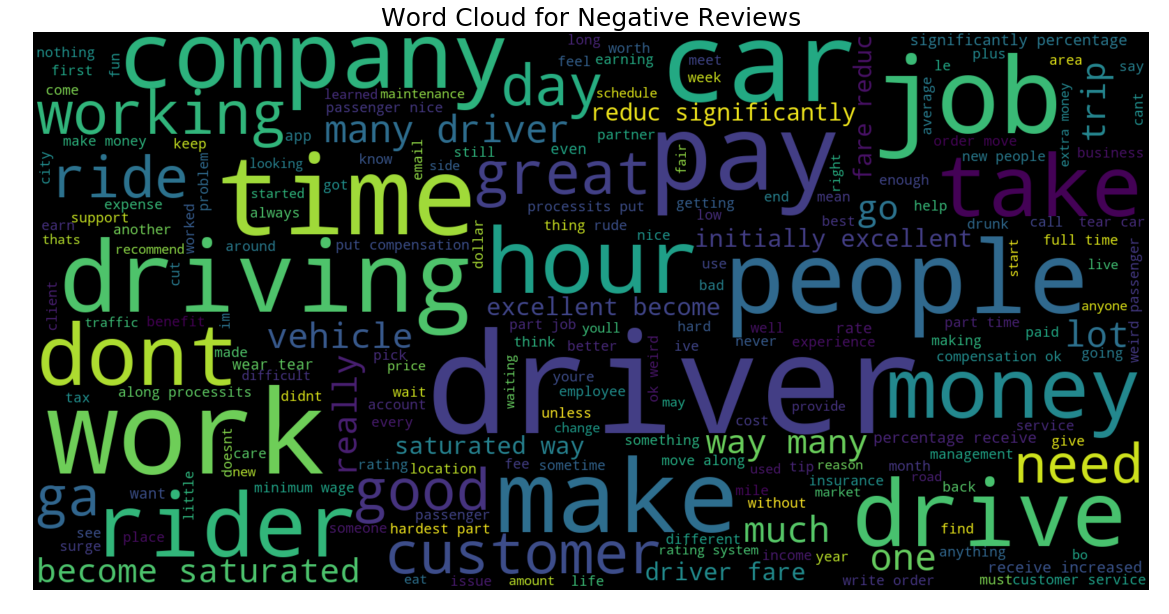

In [55]:
# Display the generated image:
word_cloud_plot(' '.join([' '.join(msg) for msg in data[data.percent_wt <= 56].clean_message]), 
                "Word Cloud for Negative Reviews")

In [56]:
pd.DataFrame(data.groupby(data.sentiment)['message'].count())

message
sentiment         
negative      1678
positive      2522

### Creating a baseline model for sentiment classification

In [57]:
#importing all the dependencies.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [58]:
cv = CountVectorizer()
tfidf_vect = TfidfVectorizer()

In [59]:
features_tfidf = tfidf_vect.fit_transform([' '.join(msg) for msg in data.clean_message])
features_cv = cv.fit_transform([' '.join(msg) for msg in data.clean_message])

In [60]:
target = data.sentiment.values

In [71]:
X_train_tfidif, X_test_tfidf, y_train, y_test = train_test_split(features_tfidf, target, test_size=0.2, random_state = 42)
X_train_cv, X_test_cv, y_train, y_test = train_test_split(features_cv, target, test_size=0.2, random_state = 42)

In [63]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import matplotlib

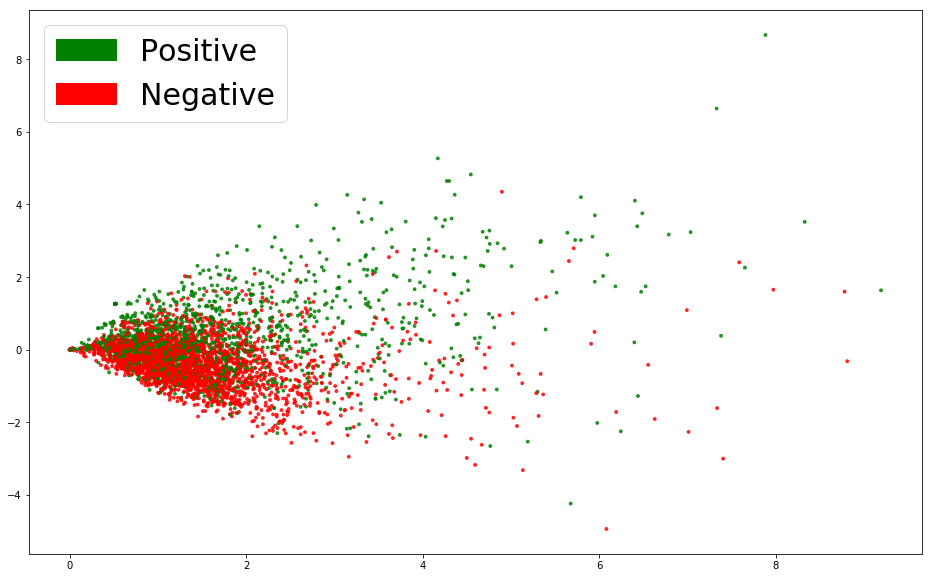

In [70]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['green','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=color_column, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='green', label='Positive')
            green_patch = mpatches.Patch(color='red', label='Negative')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 10))          
plot_LSA(features_cv, target)
plt.show()

In [75]:
model_lr_tfidf = LogisticRegression(C=0.2, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
model_lr_tfidf.fit(X_train_tfidif, y_train)

model_lr_cv = LogisticRegression(C=0.2, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
model_lr_cv.fit(X_train_cv, y_train)

y_predicted_tfidf = model_lr_tfidf.predict(X_test_tfidf)
y_predicted_cv = model_lr_cv.predict(X_test_cv)

In [77]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.771, precision = 0.770, recall = 0.771, f1 = 0.770


In [78]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_cv)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.744, precision = 0.742, recall = 0.744, f1 = 0.742


### Creating visualizations for understanding the model working

In [79]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

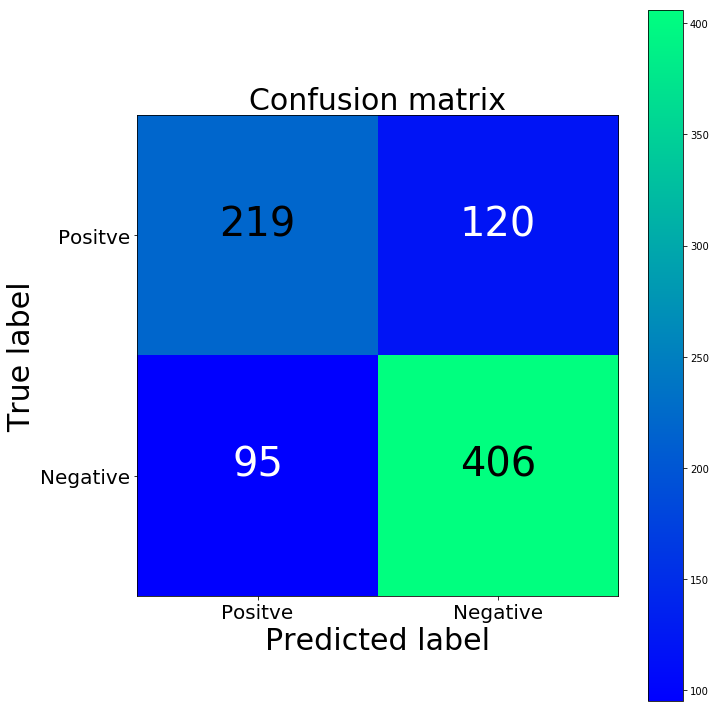

[[219 120]
 [ 95 406]]


In [80]:
cm = confusion_matrix(y_test, y_predicted_cv)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positve','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

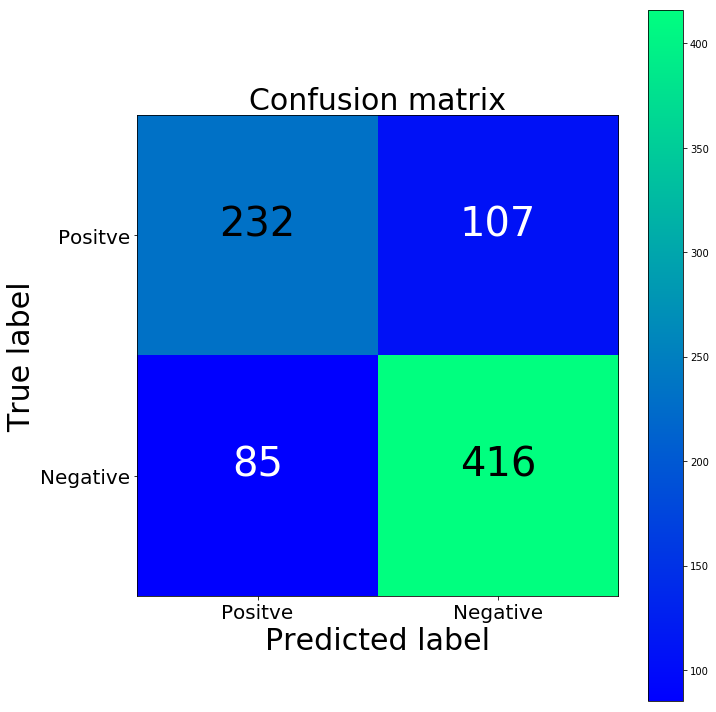

[[232 107]
 [ 85 416]]


In [81]:
cm = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positve','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [82]:
#function to get the most important features in both the classes
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [85]:
importance  = get_most_important_features(cv,model_lr_cv,10)

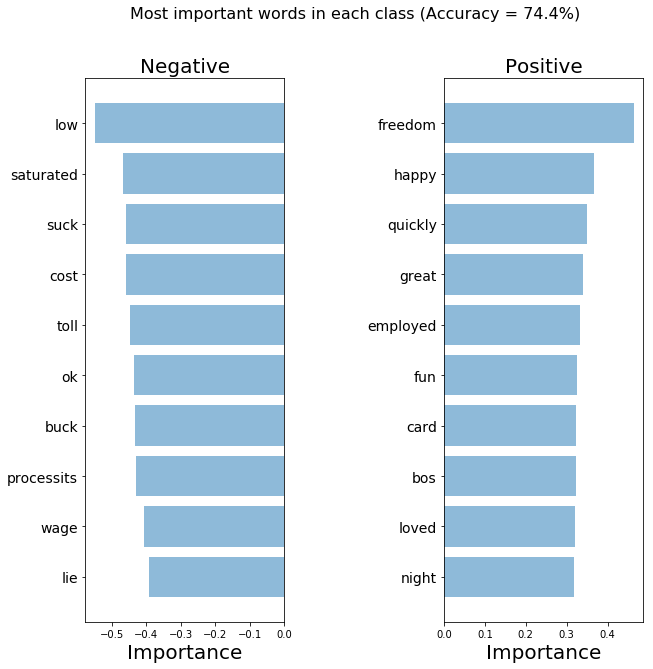

In [86]:
#function to plot the top 10 important words in the bag of words
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, f"Most important words in each class (Accuracy = {round(accuracy*100,2)}%)")

In [87]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [88]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data.clean_message.apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [89]:
embeddings = get_word2vec_embeddings(word2vec, data)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, data.sentiment.tolist(), test_size=0.2, random_state=40)

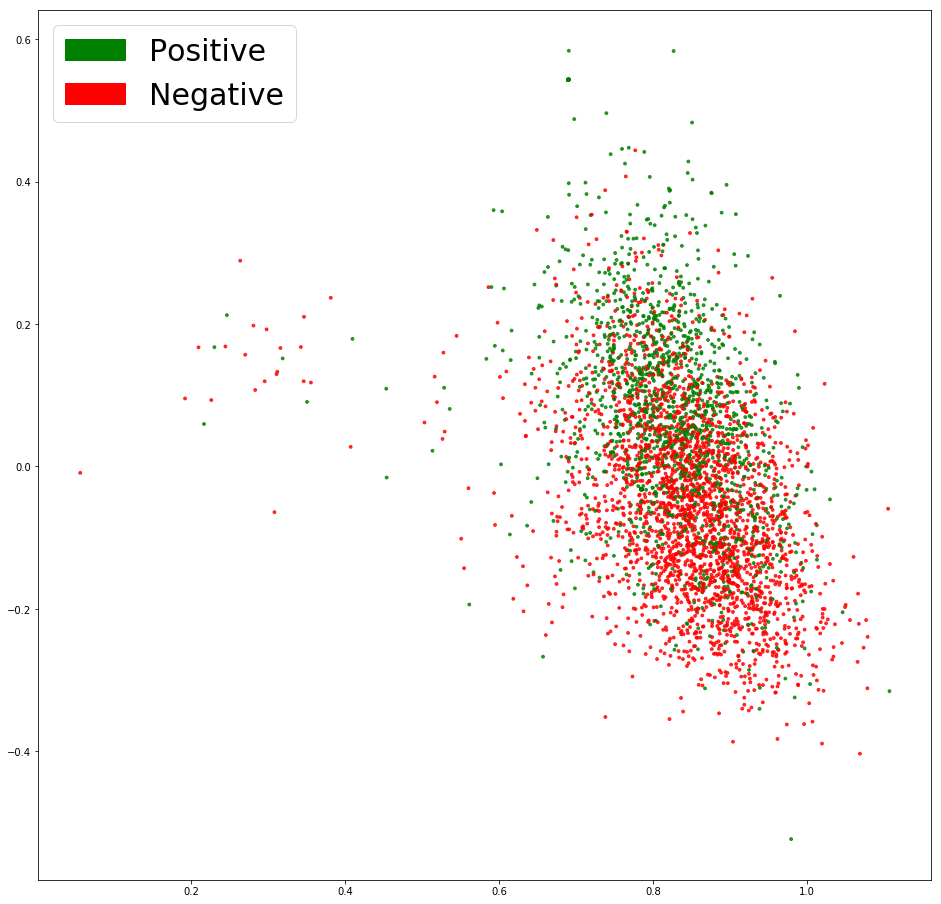

In [90]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, data.sentiment.tolist())
plt.show()

In [91]:
clf_w2v = LogisticRegression(C=0.2, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [92]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.790, precision = 0.800, recall = 0.790, f1 = 0.793


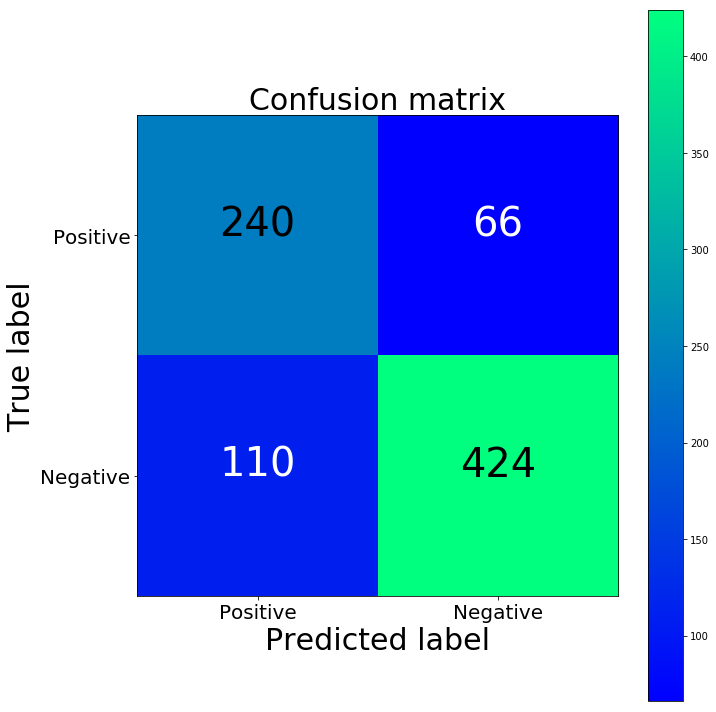

Word2Vec confusion matrix
[[240  66]
 [110 424]]


In [93]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Positive','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)

In [94]:
from sklearn.ensemble import GradientBoostingClassifier as gbc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [142]:
classifier = gbc(random_state = 42)

In [143]:
classifier.fit(X_train_word2vec, y_train_word2vec)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [144]:
y_pred_gbc = classifier.predict(X_test_word2vec)

In [145]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_pred_gbc)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.799, precision = 0.797, recall = 0.799, f1 = 0.798


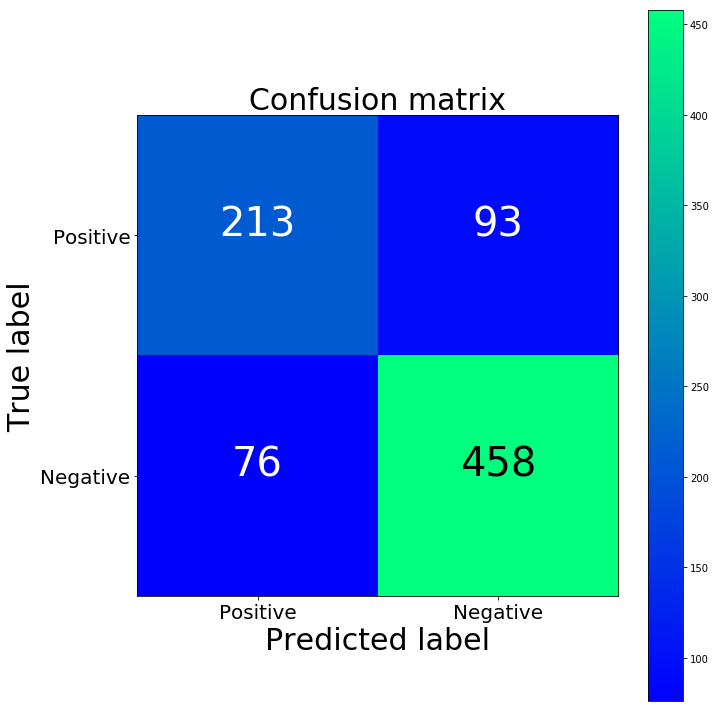

Word2Vec confusion matrix
[[213  93]
 [ 76 458]]


In [146]:
cm_w2v = confusion_matrix(y_test_word2vec, y_pred_gbc)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Positive','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)

In [103]:
from sklearn.ensemble import  RandomForestClassifier

In [131]:
rf_classifier = RandomForestClassifier(random_state = 42, n_estimators=500)

In [132]:
rf_classifier.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [133]:
rf_predict = rf_classifier.predict(X_test_word2vec)

In [149]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, rf_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.805, precision = 0.805, recall = 0.805, f1 = 0.798


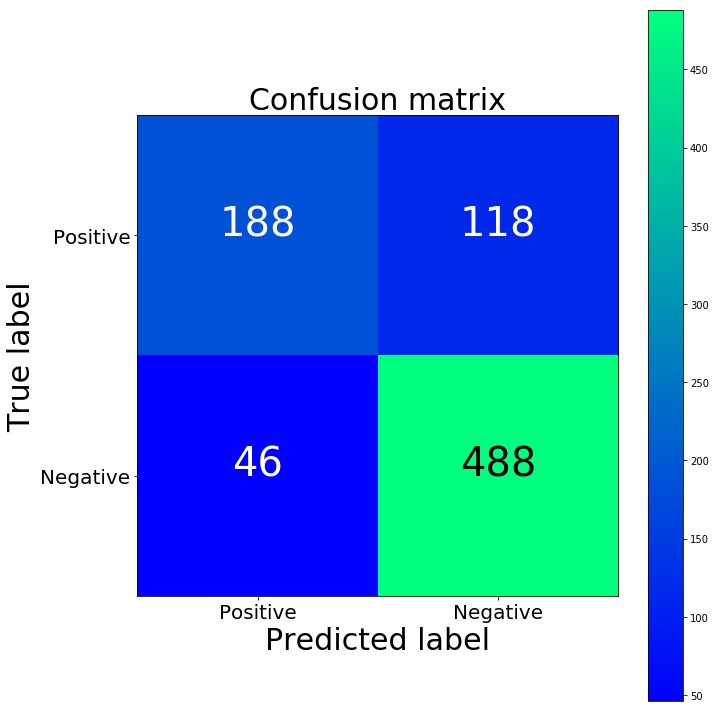

Word2Vec confusion matrix
[[188 118]
 [ 46 488]]


In [136]:
cm_w2v = confusion_matrix(y_test_word2vec ,rf_predict)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Positive','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)

In [156]:
import pickle

In [157]:
filename = 'sentiment_predictor.sav'

In [159]:
pickle.dump(rf_classifier, open(filename, 'wb'))